In [151]:
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torchattacks
import seaborn as sns
import copy

from torch.utils.data import Dataset, DataLoader, random_split, Subset
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, confusion_matrix
from sklearn.preprocessing import StandardScaler

import warnings
warnings.filterwarnings("ignore")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [152]:
def load_data(csv_path):
	df = pd.read_csv(csv_path)
	df.dropna(axis=1, how='any', inplace=True)
	
	numeric_columns = df.select_dtypes(include=[np.number])
	numeric_columns = numeric_columns.loc[:, ~np.isinf(numeric_columns.values).any(axis=0)]
	numeric_columns = numeric_columns.loc[:, numeric_columns.nunique() > 1]
	non_numeric_cols = df.select_dtypes(exclude=[np.number])
	
	df = pd.concat([non_numeric_cols, numeric_columns], axis=1)
	df.drop_duplicates(inplace=True)
	df.rename(columns={' Label': 'Label'}, inplace=True)
	
	label_col = 'Label'
	feature_cols = [col for col in df.columns if col != label_col]
	df[label_col] = df[label_col].map({'BENIGN': 0}).fillna(1)
	
	scaler = StandardScaler()
	df[feature_cols] = scaler.fit_transform(df[feature_cols])
	return df, feature_cols, label_col

In [153]:
class CICDataset(Dataset):
	def __init__(self, dataframe, features, label_col):
		self.X = torch.tensor(dataframe[features].values, dtype=torch.float32)
		self.y = torch.tensor(dataframe[label_col].values, dtype=torch.float32).unsqueeze(1)
	def __len__(self):
		return len(self.X)
	def __getitem__(self, idx):
		return self.X[idx], self.y[idx]

In [154]:
class BinaryClassifier(nn.Module):
	def __init__(self, input_dim):
		super(BinaryClassifier, self).__init__()
		
		self.net = nn.Sequential(
			nn.Linear(input_dim, 128),
			nn.ReLU(),
			nn.BatchNorm1d(128),
			nn.Dropout(0.3),

			nn.Linear(128, 64),
			nn.ReLU(),
			nn.BatchNorm1d(64),
			nn.Dropout(0.3),

			nn.Linear(64, 32),
			nn.ReLU(),
			nn.BatchNorm1d(32),
			nn.Dropout(0.2),
			
			nn.Linear(32, 1),
			nn.Sigmoid()
		)
		
	def forward(self, x):
		return self.net(x)

In [155]:
def evaluate_model(model, dataloader):
	model.eval()
	y_true, y_pred = [], []
	with torch.no_grad():
		for x, y in dataloader:
			x = x.to(device)
			output = model(x)
			pred = (output > 0.5).int().cpu().numpy()
			y_pred.extend(pred)
			y_true.extend(y.numpy())
	return y_true, y_pred

In [156]:
def plot_attack_metrics(metrics, attack_name):
	labels = ['Accuracy', 'Precision', 'Recall', 'F1-score']
	pre = [metrics["Pre-Attack"][label] for label in labels]
	post = [metrics[f"{attack_name} - Post Attack"][label] for label in labels]
	post_def = [metrics[f"{attack_name} - Post Defence"][label] for label in labels]

	groups = ['Pre-Attack', 'Post-Attack', 'Post-Defence']
	data = [pre, post, post_def]

	x = np.arange(len(groups))
	width = 0.2

	_, ax = plt.subplots(figsize=(10, 6))

	for i, label in enumerate(labels):
		ax.bar(x + (i - 1.5)*width, [d[i] for d in data], width, label=label)

	ax.set_ylabel('Score')
	ax.set_title(f'Metric Comparison for {attack_name}')
	ax.set_xticks(x)
	ax.set_xticklabels(groups)
	ax.set_ylim(0, 1)
	ax.legend()
	plt.tight_layout()
	plt.show()

In [ ]:
def adversarial_training(csv_path, subset_ratio=1.0):
	df, features, label = load_data(csv_path)
	dataset = CICDataset(df, features, label)
	
	np.random.seed(42)
	
	if subset_ratio < 1.0:
		subset_size = int(len(dataset) * subset_ratio)
		indices = np.random.permutation(len(dataset))[:subset_size]
		dataset = Subset(dataset, indices)

	train_size = int(0.8 * len(dataset))
	train_set, test_set = random_split(dataset, [train_size, len(dataset) - train_size])
	train_loader = DataLoader(train_set, batch_size=64, shuffle=True)
	test_loader = DataLoader(test_set, batch_size=64)

	model = BinaryClassifier(len(features)).to(device)
	model.load_state_dict(torch.load("best_model.pth", map_location=device))

	y_true, y_pred = evaluate_model(model, test_loader)
	
	num_epochs = 50

	metrics = {}

	metrics["Pre-Attack"] = {
		"Accuracy": round(accuracy_score(y_true, y_pred), 3),
		"Precision": round(precision_score(y_true, y_pred), 3),
		"Recall": round(recall_score(y_true, y_pred), 3),
		"F1-score": round(f1_score(y_true, y_pred), 3)
	}

	print("Pre-Attack:", metrics["Pre-Attack"])

	cm = confusion_matrix(y_true, y_pred)
	sns.heatmap(cm, annot=True, fmt='g', cmap='Blues')
	plt.title("Confusion Matrix Pre-Attack")
	plt.show()

	attacks = {
		"FGSM": torchattacks.FGSM(model, eps=0.1),
		"PGD": torchattacks.PGD(model, eps=0.1, alpha=0.01)
	}

	for name, attack in attacks.items():
		adv_preds, adv_true = [], []

		for x, y in test_loader:
			x, y = x.to(device), y.to(device).float().view(-1, 1)
			x_adv = attack(x, y)
			pred = (model(x_adv) > 0.5).int().cpu().numpy()
			adv_preds.extend(pred)
			adv_true.extend(y.cpu().numpy())

		metrics[f"{name} - Post Attack"] = {
			"Accuracy": round(accuracy_score(adv_true, adv_preds), 3),
			"Precision": round(precision_score(adv_true, adv_preds), 3),
			"Recall": round(recall_score(adv_true, adv_preds), 3),
			"F1-score": round(f1_score(adv_true, adv_preds), 3)
		}

		print("Post-Attack:", name, metrics[f"{name} - Post Attack"])

		cm = confusion_matrix(adv_true, adv_preds)
		sns.heatmap(cm, annot=True, fmt='g', cmap='Blues')
		plt.title(f"Confusion Matrix Post {name} Attack")
		plt.show()

		adv_model = BinaryClassifier(len(features)).to(device)
		adv_opt = optim.Adam(adv_model.parameters(), lr=0.001)
		loss_fn = nn.BCELoss()
		adv_model.train()

		for _ in range(num_epochs):
			for x, y in train_loader:
				x, y = x.to(device), y.to(device).float().view(-1, 1)
				x_adv = attack(x, y)
				adv_opt.zero_grad()
				out = adv_model(x_adv)
				loss = loss_fn(out, y)
				loss.backward()
				adv_opt.step()

		adv_model.eval()
		post_def_preds, post_def_true = [], []

		for x, y in test_loader:
			x_adv = attack(x.to(device), y.to(device).float().view(-1, 1))
			pred = (adv_model(x_adv) > 0.5).int().cpu().numpy()
			post_def_preds.extend(pred)
			post_def_true.extend(y.numpy())

		metrics[f"{name} - Post Defence"] = {
			"Accuracy": round(accuracy_score(post_def_true, post_def_preds), 3),
			"Precision": round(precision_score(post_def_true, post_def_preds), 3),
			"Recall": round(recall_score(post_def_true, post_def_preds), 3),
			"F1-score": round(f1_score(post_def_true, post_def_preds), 3)
		}

		print("Post-Defence:", metrics[f"{name} - Post Defence"])

		cm = confusion_matrix(post_def_true, post_def_preds)
		sns.heatmap(cm, annot=True, fmt='g', cmap='Blues')
		plt.title(f"Confusion Matrix Post {name} Defence")
		plt.show()

	for attack in attacks.keys():
		plot_attack_metrics(metrics, attack)

Pre-Attack: {'Accuracy': 0.999, 'Precision': 1.0, 'Recall': 0.999, 'F1-score': 0.999}


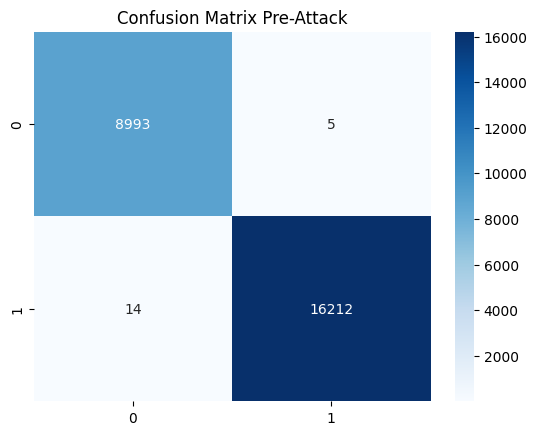

Post-Attack: FGSM {'Accuracy': 0.402, 'Precision': 0.997, 'Recall': 0.07, 'F1-score': 0.131}


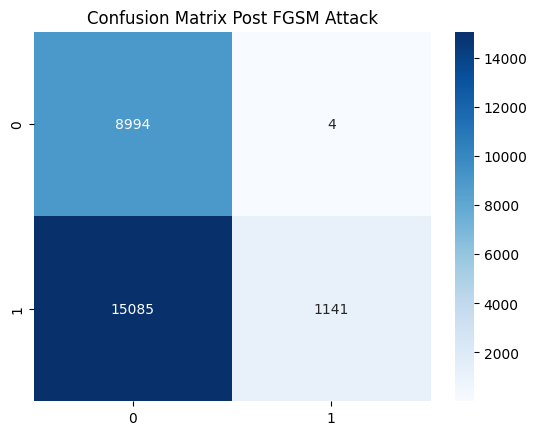

Post-Defence: {'Accuracy': 0.993, 'Precision': 0.989, 'Recall': 1.0, 'F1-score': 0.994}


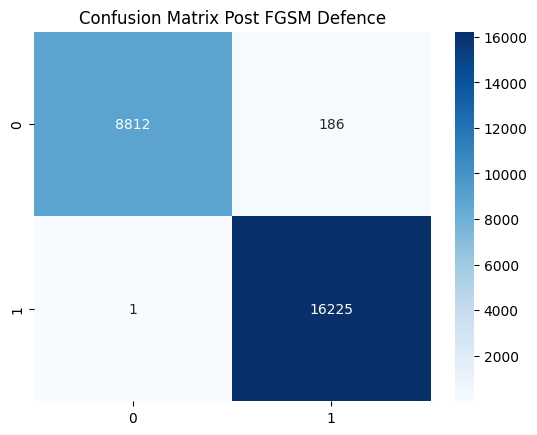

Post-Attack: PGD {'Accuracy': 0.362, 'Precision': 0.668, 'Recall': 0.016, 'F1-score': 0.031}


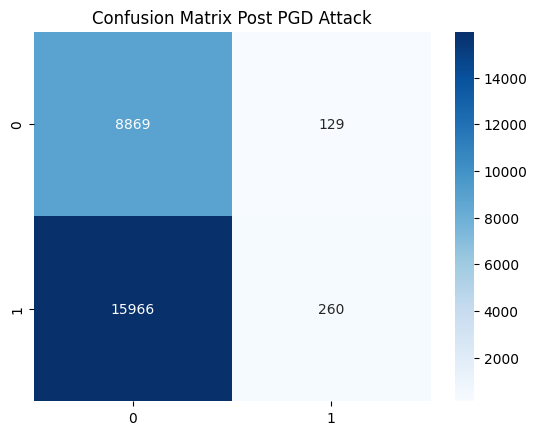

Post-Defence: {'Accuracy': 0.991, 'Precision': 0.987, 'Recall': 1.0, 'F1-score': 0.993}


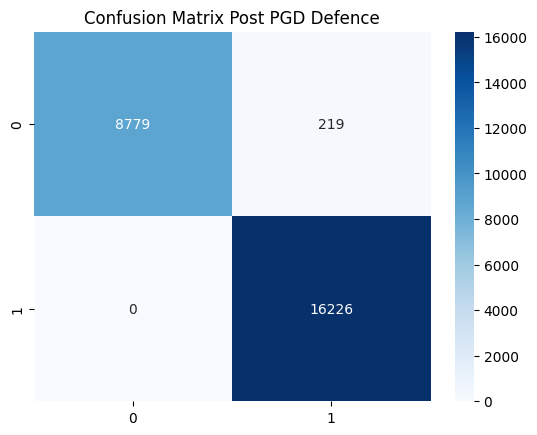

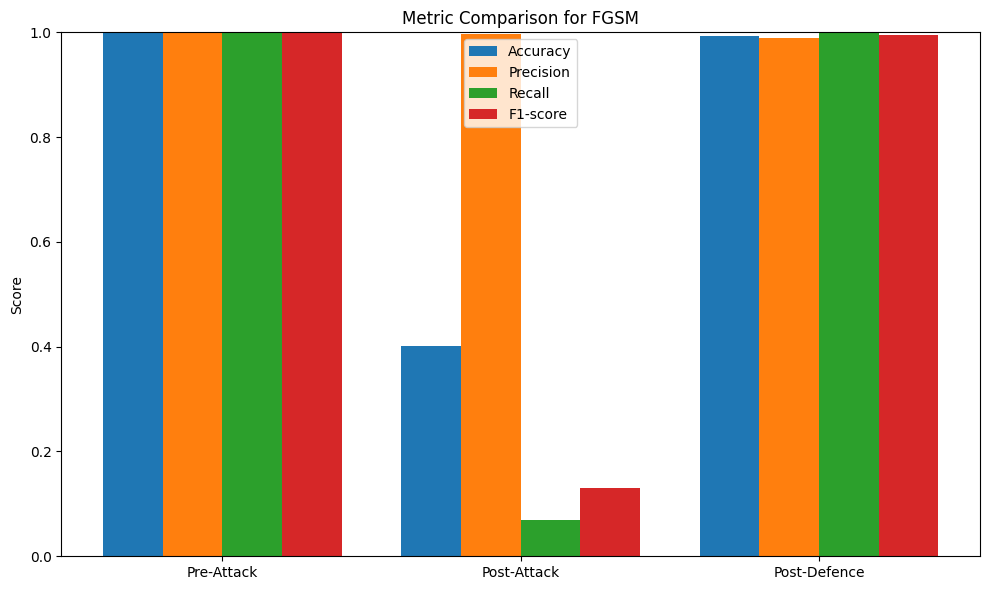

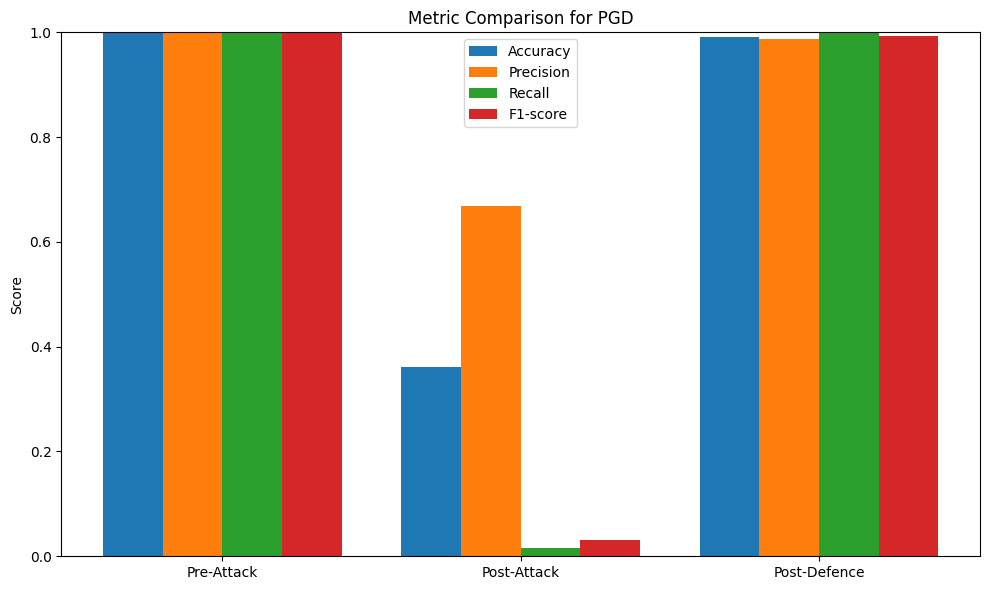

In [158]:
adversarial_training("../data/CIC-IDS-2017.csv", subset_ratio=0.05)